# Seasonal Arima Models for California Counties 

In [24]:
import warnings
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm


In [25]:
data = pd.read_csv('finalized_county.csv')

In [26]:
california_data = data[data['state'] == 'California']
california_data['date'] = pd.to_datetime(california_data['date'], format="%Y-%m-%d")
california_data['county'].unique()

array(['Los Angeles', 'Orange', 'San Diego'], dtype=object)

## Los Angeles

In [27]:
la = california_data[california_data['county'] == 'Los Angeles'].loc[:, ['date', 'incremental_cases']]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# LA data is non-stationary without any differencing
stationary_test(la.incremental_cases)

# test statistic (hypothesis that non-stationarity cannot be rejected)
# p-value is greater than 0.05 

(1.3190762222252403, 0.9967136380720155)

In [28]:
# first-level differencing
la['incremental_cases'] = la['incremental_cases'].diff().fillna(la['incremental_cases']).astype('int')

# la is still non-stationary after first-level differencing
stationary_test(la.incremental_cases)

# test statistic (hypothesis that non-stationarity cannot be rejected)
# p-value is greater than 0.05 

(-0.934092662079519, 0.7765380334868845)

In [29]:
# second-level differencing
la['incremental_cases'] = la['incremental_cases'].diff().fillna(la['incremental_cases']).astype('int')

# la is stationary after second-level differencing
stationary_test(la.incremental_cases)

# test statistic (hypothesis that non-stationarity can be rejected)
# p-value is much less than 0.05

(-8.591013100393987, 7.286147751265899e-14)

In [30]:
# using differenced cases for train
train = la.iloc[:230, :]

<Axes: xlabel='date', ylabel='incremental_cases'>

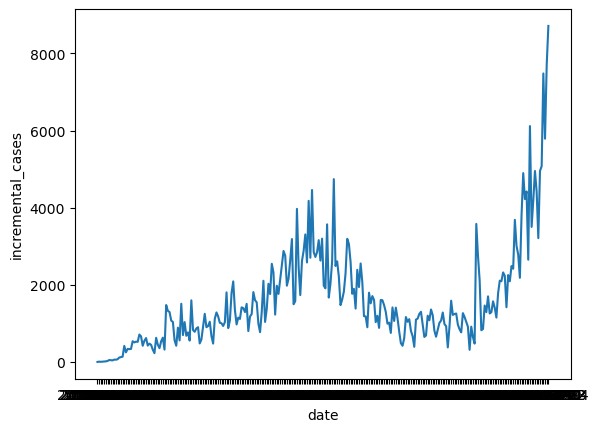

In [31]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Los Angeles'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

### Baseline Model

In [38]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(0, 0, 0), seasonal_order=(1,1,1,7)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24392D+00    |proj g|=  1.28367D-01

At iterate    5    f=  8.16226D+00    |proj g|=  4.12593D-03

At iterate   10    f=  8.16175D+00    |proj g|=  4.75473D-04

At iterate   15    f=  8.12439D+00    |proj g|=  9.43646D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     26      1     0     0   4.603D-07   8.115D+00
  F =   8.1153560897119785     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
R-square

 This problem is unconstrained.


<Axes: xlabel='date'>

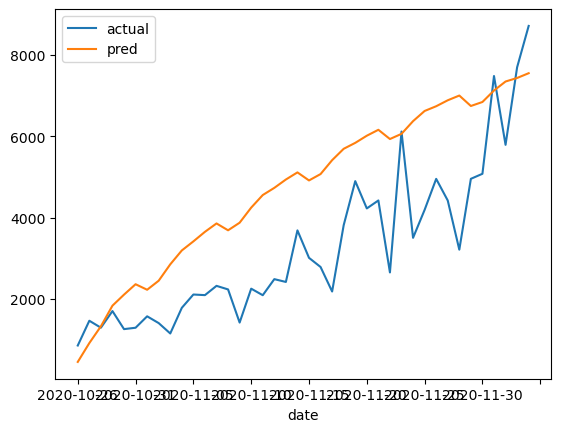

In [39]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

### Tuning Hyperparameters

In [55]:
p_values = [0, 1, 2, 3]
d_values = [0, 1, 2, 3]
q_values = [0, 1, 2, 3]

P_values = [0, 1, 2, 3]
D_values = [0, 1]
Q_values = [0, 1, 2, 3]
Season_length = [7]  # Assuming a weekly seasonality

prev_mse = float('inf')
best_params = (None, None)  # Initialized to a safer default

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for S in Season_length:
                            try:
                                model = SARIMAX(train.incremental_cases,
                                                order=(p, d, q),
                                                seasonal_order=(P, D, Q, S),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False).fit(disp=0)

                                pred = model.forecast(steps=40)
                                pred = pd.concat([pd.Series([-62]), pred]).cumsum()[1:]
                                pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]

                                mse = mean_squared_error(test.incremental_cases, pred)

                                if mse < prev_mse:
                                    prev_mse = mse
                                    best_params = ((p, d, q), (P, D, Q, S))

                                print(f"MSE: {mse} for parameters (p, d, q): {(p, d, q)} and (P, D, Q, S): {(P, D, Q, S)}")
                            except Exception as e:
                                print(f"Failed to fit model for parameters (p, d, q): {(p, d, q)}, (P, D, Q, S): {(P, D, Q, S)}. Error: {e}")

if best_params[0] is not None:
    print(f"Best Parameters: Non-seasonal (p, d, q): {best_params[0]}, Seasonal (P, D, Q, S): {best_params[1]} with MSE: {prev_mse}")
else:
    print("No successful model fit was found.")


MSE: 26384820.825 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (0, 0, 0, 7)
MSE: 37140739.18327451 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 40337199.7592796 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (0, 0, 2, 7)
MSE: 65905421.3937665 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (0, 0, 3, 7)
MSE: 346559612.15 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (0, 1, 0, 7)
MSE: 6326112.295264287 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (0, 1, 1, 7)
MSE: 4535730.166489491 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 11426448.563254356 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 35393212.09317785 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 52659695.33075215 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 40366035.19386231 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 66140973.5822593

MSE: 782552709.5581458 for parameters (p, d, q): (0, 0, 2) and (P, D, Q, S): (3, 1, 0, 7)
MSE: 781700341.9145801 for parameters (p, d, q): (0, 0, 2) and (P, D, Q, S): (3, 1, 1, 7)
MSE: 776227080.738457 for parameters (p, d, q): (0, 0, 2) and (P, D, Q, S): (3, 1, 2, 7)
MSE: 772111731.7145216 for parameters (p, d, q): (0, 0, 2) and (P, D, Q, S): (3, 1, 3, 7)
MSE: 725632209.9937279 for parameters (p, d, q): (0, 0, 3) and (P, D, Q, S): (0, 0, 0, 7)
MSE: 733289421.9396001 for parameters (p, d, q): (0, 0, 3) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 733545405.2477119 for parameters (p, d, q): (0, 0, 3) and (P, D, Q, S): (0, 0, 2, 7)
MSE: 731164959.9415816 for parameters (p, d, q): (0, 0, 3) and (P, D, Q, S): (0, 0, 3, 7)
MSE: 741958063.5144422 for parameters (p, d, q): (0, 0, 3) and (P, D, Q, S): (0, 1, 0, 7)
MSE: 753143521.4220713 for parameters (p, d, q): (0, 0, 3) and (P, D, Q, S): (0, 1, 1, 7)
MSE: 772751170.553789 for parameters (p, d, q): (0, 0, 3) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 7891143

MSE: 37360270.62587871 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (2, 1, 3, 7)
MSE: 98034111.02583453 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (3, 0, 0, 7)
MSE: 141153336.15056676 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (3, 0, 1, 7)
MSE: 143945342.37100393 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (3, 0, 2, 7)
MSE: 136458118.7003955 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (3, 0, 3, 7)
MSE: 333158266.36213446 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (3, 1, 0, 7)
MSE: 26817441.872443117 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (3, 1, 1, 7)
MSE: 54469382.93295089 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (3, 1, 2, 7)
MSE: 87407966.04949671 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (3, 1, 3, 7)
MSE: 652180692.7278825 for parameters (p, d, q): (0, 1, 2) and (P, D, Q, S): (0, 0, 0, 7)
MSE: 706666125.7958735 for parameters (p, d, q): (0, 1, 2) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 5

MSE: 12181270893564.434 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (2, 0, 3, 7)
MSE: 41154648394534.77 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (2, 1, 0, 7)
MSE: 4894462979738.104 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (2, 1, 1, 7)
MSE: 2048383241799.0 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (2, 1, 2, 7)
MSE: 5531548537881.339 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (2, 1, 3, 7)
MSE: 25734549375675.51 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (3, 0, 0, 7)
MSE: 13562026860090.354 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (3, 0, 1, 7)
MSE: 13166357894290.203 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (3, 0, 2, 7)
MSE: 12229667572446.178 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (3, 0, 3, 7)
MSE: 41253535730005.14 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (3, 1, 0, 7)
MSE: 12460221724582.855 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (3, 1, 1, 7)
MSE: 32

MSE: 118170969.0634208 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 278529706.51113623 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 445956987.3361886 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 565905748.895788 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (2, 0, 1, 7)
MSE: 474397963.92370987 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (2, 0, 2, 7)
MSE: 413723385.8607072 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (2, 0, 3, 7)
MSE: 2051651260.4400818 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (2, 1, 0, 7)
MSE: 1226420238.8963122 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (2, 1, 1, 7)
MSE: 179271724.7759737 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (2, 1, 2, 7)
MSE: 115143741.75169227 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (2, 1, 3, 7)
MSE: 425989176.7613842 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (3, 0, 0, 7)
MSE: 4

MSE: 535664886520.85156 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 2071251332936.0461 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 548591902622.31104 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 783898734328.8958 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (1, 1, 0, 7)
MSE: 50289261092.03735 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 6252905544929.1875 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 833059155563.1342 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 1296091823379.9363 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 3333428199815.1772 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (2, 0, 1, 7)
MSE: 765392093710.2262 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (2, 0, 2, 7)
MSE: 3446487849693.9033 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (2, 0, 3, 7)
MSE

MSE: 664009467.375095 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 667810357.7531601 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 673663760.919733 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 674825729.4262011 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 675181992.1826321 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 678360322.6018946 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 748601648.7284166 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (1, 1, 0, 7)
MSE: 665105965.1605303 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 667690959.2580235 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 666808890.1364822 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 675410714.1109239 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 6758713

MSE: 393063161.26256377 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (0, 1, 1, 7)
MSE: 294926130.95267904 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 7203520.522303951 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 12957344683.155767 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 11920195964.590338 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 13045221845.390436 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 11798101104.312214 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 3314126843.531568 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (1, 1, 0, 7)
MSE: 407593428.6027302 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 152958698.824115 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 4879595.788415234 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 

MSE: 778840985.9782877 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 779197917.6762974 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (0, 0, 2, 7)
MSE: 767097362.074507 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (0, 0, 3, 7)
MSE: 1012048628.3238316 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (0, 1, 0, 7)
MSE: 1015559704.2191718 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (0, 1, 1, 7)
MSE: 1026765948.3388418 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 1052935242.2339277 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 781419529.4801625 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 830831315.7942065 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 816802741.2763445 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 833940508.3044116 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 10

MSE: 7919809046.061441 for parameters (p, d, q): (1, 2, 1) and (P, D, Q, S): (3, 1, 0, 7)
MSE: 872285162.221098 for parameters (p, d, q): (1, 2, 1) and (P, D, Q, S): (3, 1, 1, 7)
MSE: 2750772273.258743 for parameters (p, d, q): (1, 2, 1) and (P, D, Q, S): (3, 1, 2, 7)
MSE: 2843491243.3297186 for parameters (p, d, q): (1, 2, 1) and (P, D, Q, S): (3, 1, 3, 7)
MSE: 764040537.5058973 for parameters (p, d, q): (1, 2, 2) and (P, D, Q, S): (0, 0, 0, 7)
MSE: 791506358.5223701 for parameters (p, d, q): (1, 2, 2) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 1031359923.7777561 for parameters (p, d, q): (1, 2, 2) and (P, D, Q, S): (0, 0, 2, 7)
MSE: 1660765808.1023889 for parameters (p, d, q): (1, 2, 2) and (P, D, Q, S): (0, 0, 3, 7)
MSE: 6024858400.219996 for parameters (p, d, q): (1, 2, 2) and (P, D, Q, S): (0, 1, 0, 7)
MSE: 1110999728.5779698 for parameters (p, d, q): (1, 2, 2) and (P, D, Q, S): (0, 1, 1, 7)
MSE: 1401122267.0147908 for parameters (p, d, q): (1, 2, 2) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 3

MSE: 2.086719610193865e+16 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (2, 1, 2, 7)
MSE: 2.050548856251623e+16 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (2, 1, 3, 7)
MSE: 1.559704369269634e+16 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (3, 0, 0, 7)
MSE: 1.6225180647689568e+16 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (3, 0, 1, 7)
MSE: 1.6793943271928448e+16 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (3, 0, 2, 7)
MSE: 1.6767408313276e+16 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (3, 0, 3, 7)
MSE: 2.582602791513208e+16 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (3, 1, 0, 7)
MSE: 1.951371739243695e+16 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (3, 1, 1, 7)
MSE: 2.070876297123103e+16 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (3, 1, 2, 7)
MSE: 2.032103742664212e+16 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (3, 1, 3, 7)
MSE: 43484698630287.71 for parameters (p, d, q): (1, 3, 1) a

MSE: 224419187195.06378 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (2, 0, 1, 7)
MSE: 148553415297.6678 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (2, 0, 2, 7)
MSE: 235734733689.9826 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (2, 0, 3, 7)
MSE: 1807166922140.724 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (2, 1, 0, 7)
MSE: 1215061759823.313 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (2, 1, 1, 7)
MSE: 458548416062.86096 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (2, 1, 2, 7)
MSE: 281253355132.74475 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (2, 1, 3, 7)
MSE: 178757991084.21597 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (3, 0, 0, 7)
MSE: 226287911467.74463 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (3, 0, 1, 7)
MSE: 148292696975.09518 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (3, 0, 2, 7)
MSE: 95544276782.7831 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (3, 0, 3, 7)
MSE: 

MSE: 769373360.0524966 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 762737167.8999226 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 764439960.3598303 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 671536643.5230755 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 671638597.5993164 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (2, 0, 1, 7)
MSE: 675839963.347984 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (2, 0, 2, 7)
MSE: 675114827.9789667 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (2, 0, 3, 7)
MSE: 761058495.513787 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (2, 1, 0, 7)
MSE: 767489686.5188634 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (2, 1, 1, 7)
MSE: 763376386.9401066 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (2, 1, 2, 7)
MSE: 759941712.9292784 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (2, 1, 3, 7)
MSE: 6758882

MSE: 1765131.5881753191 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 1583293.2879351233 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 9296313.47013458 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 179859639.31097078 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (1, 1, 0, 7)
MSE: 7178633.472212419 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 6489277.408816023 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 7475959.705911401 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 3358788.638891117 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 11756414.704320055 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (2, 0, 1, 7)
MSE: 6678989.594519494 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (2, 0, 2, 7)
MSE: 4195312.124072273 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (2, 0, 3, 7)
MSE: 59

MSE: 8058934917.0767765 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 78402578709.02763 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 332756622499.0882 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 234938381938.64746 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 307415049975.6794 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 274452393270.21014 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 671638725863.8427 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (1, 1, 0, 7)
MSE: 3492403639.65766 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 42548885139.144936 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 3295541016.8888025 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 305191812541.54767 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 

MSE: 981726128.7034752 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 1052940630.7123382 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (0, 0, 2, 7)
MSE: 845004376.1827705 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (0, 0, 3, 7)
MSE: 3406369571.274115 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (0, 1, 0, 7)
MSE: 2316408345.3122873 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (0, 1, 1, 7)
MSE: 991819327.0713259 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 570455039.6193011 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 1006523464.7301786 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 978476904.1895905 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 1025976109.0359997 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 1277367387.216605 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 2

MSE: 428583303972.5216 for parameters (p, d, q): (2, 3, 1) and (P, D, Q, S): (3, 1, 0, 7)
MSE: 3316283548.3888535 for parameters (p, d, q): (2, 3, 1) and (P, D, Q, S): (3, 1, 1, 7)
MSE: 46249285001.27196 for parameters (p, d, q): (2, 3, 1) and (P, D, Q, S): (3, 1, 2, 7)
MSE: 231529079756.39404 for parameters (p, d, q): (2, 3, 1) and (P, D, Q, S): (3, 1, 3, 7)
MSE: 393172227626.9457 for parameters (p, d, q): (2, 3, 2) and (P, D, Q, S): (0, 0, 0, 7)
MSE: 425357077239.5929 for parameters (p, d, q): (2, 3, 2) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 462677239057.576 for parameters (p, d, q): (2, 3, 2) and (P, D, Q, S): (0, 0, 2, 7)
MSE: 690106453529.5299 for parameters (p, d, q): (2, 3, 2) and (P, D, Q, S): (0, 0, 3, 7)
MSE: 1101194553666.225 for parameters (p, d, q): (2, 3, 2) and (P, D, Q, S): (0, 1, 0, 7)
MSE: 2431134792070.491 for parameters (p, d, q): (2, 3, 2) and (P, D, Q, S): (0, 1, 1, 7)
MSE: 815695356459.8776 for parameters (p, d, q): (2, 3, 2) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 3622

MSE: 369711985.3610071 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (2, 1, 3, 7)
MSE: 314437851.7983899 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (3, 0, 0, 7)
MSE: 299947399.0751415 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (3, 0, 1, 7)
MSE: 301266471.1178206 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (3, 0, 2, 7)
MSE: 297855645.0740862 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (3, 0, 3, 7)
MSE: 351710929.55438626 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (3, 1, 0, 7)
MSE: 386972806.1607312 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (3, 1, 1, 7)
MSE: 375654614.6188606 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (3, 1, 2, 7)
MSE: 368272359.40304995 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (3, 1, 3, 7)
MSE: 699385874.1825829 for parameters (p, d, q): (3, 0, 1) and (P, D, Q, S): (0, 0, 0, 7)
MSE: 718043897.7032607 for parameters (p, d, q): (3, 0, 1) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 718

MSE: 728130301.7117926 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (2, 0, 3, 7)
MSE: 774364313.1836119 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (2, 1, 0, 7)
MSE: 774385484.6711409 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (2, 1, 1, 7)
MSE: 765379240.4080617 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (2, 1, 2, 7)
MSE: 759883203.2893375 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (2, 1, 3, 7)
MSE: 737934375.6110874 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (3, 0, 0, 7)
MSE: 734238945.2951119 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (3, 0, 1, 7)
MSE: 733460431.5224854 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (3, 0, 2, 7)
MSE: 735305267.9741328 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (3, 0, 3, 7)
MSE: 763039893.2762642 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (3, 1, 0, 7)
MSE: 768057738.1762836 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (3, 1, 1, 7)
MSE: 76553

MSE: 1154456840.9583209 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 1142509662.7909257 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 918923157.6090767 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 920387086.0685676 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (2, 0, 1, 7)
MSE: 926873360.7739681 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (2, 0, 2, 7)
MSE: 899041734.4188976 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (2, 0, 3, 7)
MSE: 968790098.4097697 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (2, 1, 0, 7)
MSE: 960083513.3088077 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (2, 1, 1, 7)
MSE: 1206408414.5243824 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (2, 1, 2, 7)
MSE: 1071840872.0923958 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (2, 1, 3, 7)
MSE: 897459202.6786144 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (3, 0, 0, 7)
MSE: 9

MSE: 107140152463.58524 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 155759090484.83563 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 135962026714.1138 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 197628502708.37912 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (1, 1, 0, 7)
MSE: 94384123368.05553 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 93136742318.11584 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 96879177394.65742 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 112412691937.53996 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 79170369803.01665 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (2, 0, 1, 7)
MSE: 116578607069.51904 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (2, 0, 2, 7)
MSE: 131790110799.55759 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (2, 0, 3, 7)
MSE:

MSE: 14713213934723.744 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 40432009448250.98 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 4399805267355.345 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 1897614488374.838 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 3276702954545.1016 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 16548705538352.14 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 24272170692607.465 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (1, 1, 0, 7)
MSE: 12144763370250.854 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 42639408792618.76 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 47341510202405.65 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 4585119550945.331 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 2

MSE: 619681717.1713235 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 11003706712.770319 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (0, 0, 2, 7)
MSE: 146629005.36643267 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (0, 0, 3, 7)
MSE: 1250897033.8161082 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (0, 1, 0, 7)
MSE: 12901075488.84631 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (0, 1, 1, 7)
MSE: 19259649983.537647 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 39625143460.96358 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 98997188049.66312 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 987438461.1535248 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 873969905.2839944 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 246875341.43495578 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 

In [56]:
model = model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(1, 0, 0), seasonal_order=(0,0,2,7)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.08603D+00    |proj g|=  3.11719D-02

At iterate    5    f=  8.08529D+00    |proj g|=  8.67139D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   4.699D-05   8.085D+00
  F =   8.0852911840916697     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


0.7705731533024922

<Axes: xlabel='date'>

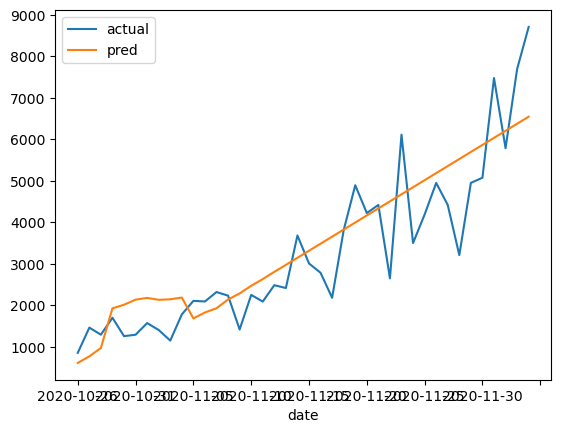

In [57]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

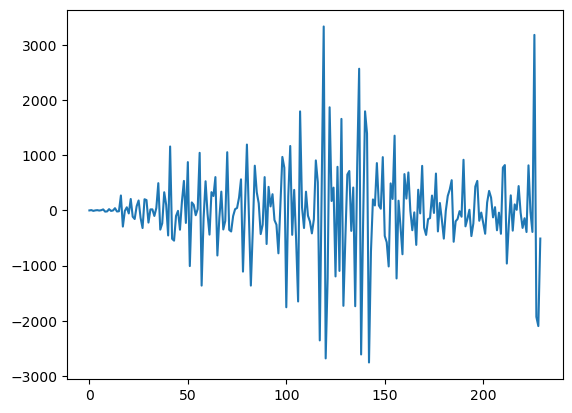

In [58]:
plt.plot(model.resid)

In [59]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                      incremental_cases   No. Observations:                  230
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 2], 7)   Log Likelihood               -1859.617
Date:                                Tue, 20 Feb 2024   AIC                           3727.234
Time:                                        13:38:47   BIC                           3740.986
Sample:                                             0   HQIC                          3732.781
                                                - 230                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6005      0.034    -17.512      0.000      -0.668      -0.533
ma.S.L7        0.2430      0.063      3.865      0.000       0.120       0.366
ma.S.L14      -0.1655      0.063     -2.636      0.008      -0.289      -0.042
sigma2      6.366e+05   3.68e+04     17.299      0.000    5.64e+05    7.09e+05
===================================================================================
Ljung-Box (L1) (Q):                  13.35   Jarque-Bera (JB):               160.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.83   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Orange

In [72]:
orange = california_data[california_data['county'] == 'Orange'].loc[:, ['date', 'incremental_cases']]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# Orange data is non-stationary without any differencing
stationary_test(orange.incremental_cases)

# test statistic (hypothesis that non-stationarity cannot be rejected)
# p-value is greater than 0.05 

(-0.1897980045327783, 0.9397267929055788)

In [73]:
# first-level differencing
orange['incremental_cases'] = orange['incremental_cases'].diff().fillna(orange['incremental_cases']).astype('int')

# la is still non-stationary after first-level differencing
stationary_test(orange.incremental_cases)

# test statistic (hypothesis that non-stationarity can be rejected)
# p-value is much less than 0.05

(-10.476734705085976, 1.243438566263163e-18)

In [74]:
# using differenced cases for train
train = orange.iloc[:230, :]

<Axes: xlabel='date', ylabel='incremental_cases'>

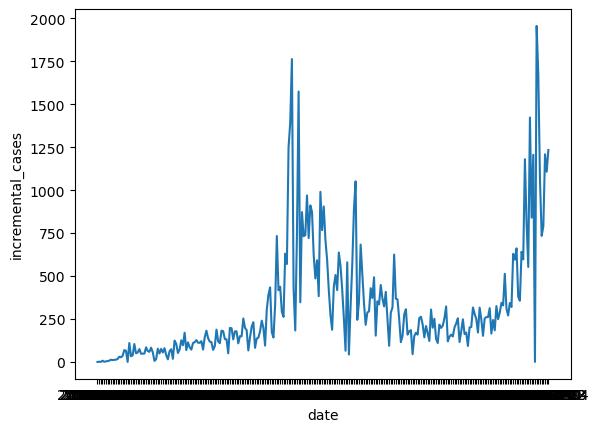

In [75]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Orange'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

### Baseline Model

In [76]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(0, 0, 0), seasonal_order=(1,1,1,7)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71295D+00    |proj g|=  1.24131D-01

At iterate    5    f=  6.64168D+00    |proj g|=  2.32355D-03

At iterate   10    f=  6.58376D+00    |proj g|=  5.71088D-02

At iterate   15    f=  6.58092D+00    |proj g|=  1.89280D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     20      1     0     0   1.893D-06   6.581D+00
  F =   6.5809230360467019     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
R-square

 This problem is unconstrained.


<Axes: xlabel='date'>

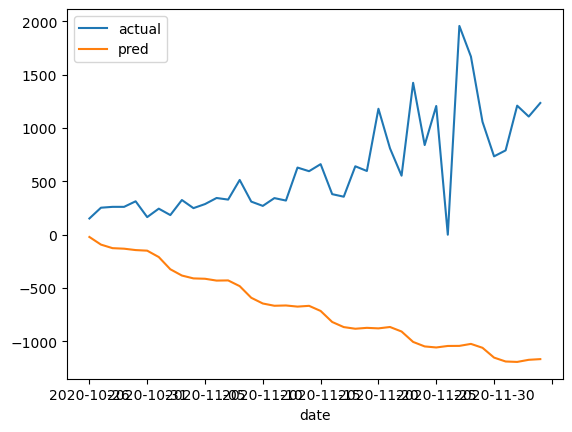

In [77]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

### Tuning Hyperparameters

In [78]:
p_values = [0, 1, 2, 3]
d_values = [0, 1, 2, 3]
q_values = [0, 1, 2, 3]

P_values = [0, 1, 2, 3]
D_values = [0, 1]
Q_values = [0, 1, 2, 3]
Season_length = [7]  # Assuming a weekly seasonality

prev_mse = float('inf')
best_params = (None, None)  # Initialized to a safer default

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for S in Season_length:
                            try:
                                model = SARIMAX(train.incremental_cases,
                                                order=(p, d, q),
                                                seasonal_order=(P, D, Q, S),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False).fit(disp=0)

                                pred = model.forecast(steps=40)
                                pred = pd.concat([pd.Series([-62]), pred]).cumsum()[1:]
                                pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]

                                mse = mean_squared_error(test.incremental_cases, pred)

                                if mse < prev_mse:
                                    prev_mse = mse
                                    best_params = ((p, d, q), (P, D, Q, S))

                                print(f"MSE: {mse} for parameters (p, d, q): {(p, d, q)} and (P, D, Q, S): {(P, D, Q, S)}")
                            except Exception as e:
                                print(f"Failed to fit model for parameters (p, d, q): {(p, d, q)}, (P, D, Q, S): {(P, D, Q, S)}. Error: {e}")

if best_params[0] is not None:
    print(f"Best Parameters: Non-seasonal (p, d, q): {best_params[0]}, Seasonal (P, D, Q, S): {best_params[1]} with MSE: {prev_mse}")
else:
    print("No successful model fit was found.")


MSE: 4393760.75 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (0, 0, 0, 7)
MSE: 4726794.491229144 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 4326592.011151667 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (0, 0, 2, 7)
MSE: 5224626.096761757 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (0, 0, 3, 7)
MSE: 1418673.05 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (0, 1, 0, 7)
MSE: 1778208.8249391697 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (0, 1, 1, 7)
MSE: 1965745.8414487094 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 1301553.4100431863 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 4707458.840005671 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 4705319.68151432 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 4521530.037093033 for parameters (p, d, q): (0, 0, 0) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 5296469.562689776

MSE: 4867381.561539667 for parameters (p, d, q): (0, 0, 2) and (P, D, Q, S): (3, 1, 1, 7)
MSE: 4818574.725206715 for parameters (p, d, q): (0, 0, 2) and (P, D, Q, S): (3, 1, 2, 7)
MSE: 4471598.736762779 for parameters (p, d, q): (0, 0, 2) and (P, D, Q, S): (3, 1, 3, 7)
MSE: 5885465.285734715 for parameters (p, d, q): (0, 0, 3) and (P, D, Q, S): (0, 0, 0, 7)
MSE: 5894039.418555017 for parameters (p, d, q): (0, 0, 3) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 5886293.782194982 for parameters (p, d, q): (0, 0, 3) and (P, D, Q, S): (0, 0, 2, 7)
MSE: 6082466.59542572 for parameters (p, d, q): (0, 0, 3) and (P, D, Q, S): (0, 0, 3, 7)
MSE: 1942216.6466590737 for parameters (p, d, q): (0, 0, 3) and (P, D, Q, S): (0, 1, 0, 7)
MSE: 4100111.492419845 for parameters (p, d, q): (0, 0, 3) and (P, D, Q, S): (0, 1, 1, 7)
MSE: 4401938.695173803 for parameters (p, d, q): (0, 0, 3) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 4494833.652535426 for parameters (p, d, q): (0, 0, 3) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 58977

MSE: 4498187.811808002 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (3, 0, 0, 7)
MSE: 4391195.891339513 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (3, 0, 1, 7)
MSE: 4412769.592632481 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (3, 0, 2, 7)
MSE: 4028057.396060458 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (3, 0, 3, 7)
MSE: 16519742.792975742 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (3, 1, 0, 7)
MSE: 9077241.983935822 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (3, 1, 1, 7)
MSE: 9066610.689788992 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (3, 1, 2, 7)
MSE: 5833490.451894577 for parameters (p, d, q): (0, 1, 1) and (P, D, Q, S): (3, 1, 3, 7)
MSE: 2728309.61673709 for parameters (p, d, q): (0, 1, 2) and (P, D, Q, S): (0, 0, 0, 7)
MSE: 2685755.341195603 for parameters (p, d, q): (0, 1, 2) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 2855461.9311542376 for parameters (p, d, q): (0, 1, 2) and (P, D, Q, S): (0, 0, 2, 7)
MSE: 3181

MSE: 656932656361.1527 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (2, 0, 3, 7)
MSE: 2854540530255.6587 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (2, 1, 0, 7)
MSE: 114786654808.92758 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (2, 1, 1, 7)
MSE: 131903627394.12393 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (2, 1, 2, 7)
MSE: 127242178261.60129 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (2, 1, 3, 7)
MSE: 723954668782.741 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (3, 0, 0, 7)
MSE: 656030428972.5182 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (3, 0, 1, 7)
MSE: 626829082241.7078 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (3, 0, 2, 7)
MSE: 618152671586.8492 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (3, 0, 3, 7)
MSE: 2717010198721.4053 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (3, 1, 0, 7)
MSE: 163968492745.74945 for parameters (p, d, q): (0, 2, 0) and (P, D, Q, S): (3, 1, 1, 7)
MSE: 

MSE: 17646299.092671104 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 15949796.775499608 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 323071.61040329124 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 355135.97252973344 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (2, 0, 1, 7)
MSE: 635330.598026953 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (2, 0, 2, 7)
MSE: 501205.48076784366 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (2, 0, 3, 7)
MSE: 3517911.3590154164 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (2, 1, 0, 7)
MSE: 23252276.28870385 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (2, 1, 1, 7)
MSE: 17394936.73582328 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (2, 1, 2, 7)
MSE: 5076773.288848104 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (2, 1, 3, 7)
MSE: 342962.9823585529 for parameters (p, d, q): (0, 2, 3) and (P, D, Q, S): (3, 0, 0, 7)
MSE: 

MSE: 1578157640.2165802 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 332335453.67753893 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 1008155852.3999313 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 19042905549.35239 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (1, 1, 0, 7)
MSE: 2453355859.274692 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 41903414.87781067 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 1771221949.1069596 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 1645222745.79489 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 1947681487.8613014 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (2, 0, 1, 7)
MSE: 2105598655.7115147 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (2, 0, 2, 7)
MSE: 7016485445.56014 for parameters (p, d, q): (0, 3, 2) and (P, D, Q, S): (2, 0, 3, 7)
MSE: 1

MSE: 4242700.694293305 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 4366503.147113147 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 5695243.763605559 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 5682005.691902192 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 5769082.268069679 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 5887059.646431801 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 5305636.183757777 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (1, 1, 0, 7)
MSE: 4139519.420342409 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 3889183.81331029 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 4461822.083939256 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 5752252.625697734 for parameters (p, d, q): (1, 0, 1) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 583187

MSE: 2448590.2339099096 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (0, 0, 3, 7)
MSE: 398232082.1060678 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (0, 1, 0, 7)
MSE: 233577919.0375598 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (0, 1, 1, 7)
MSE: 309890220.85892576 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 424746274.56417006 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 7291331.080128449 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 7876055.403504146 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 8520728.563436942 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 1908609.3184418739 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 173141892.7899035 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (1, 1, 0, 7)
MSE: 292924222.80416834 for parameters (p, d, q): (1, 1, 0) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 

MSE: 432126.7187261221 for parameters (p, d, q): (1, 1, 2) and (P, D, Q, S): (3, 1, 2, 7)
MSE: 6899054.821299216 for parameters (p, d, q): (1, 1, 2) and (P, D, Q, S): (3, 1, 3, 7)
MSE: 3558246.583987771 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (0, 0, 0, 7)
MSE: 3620671.769248124 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 7426293.723327784 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (0, 0, 2, 7)
MSE: 7597303.483477794 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (0, 0, 3, 7)
MSE: 258523.5568863376 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (0, 1, 0, 7)
MSE: 15583696.51265179 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (0, 1, 1, 7)
MSE: 1924211.5871615768 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 5660822.861053843 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 3604755.5741258906 for parameters (p, d, q): (1, 1, 3) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 603

MSE: 818214.220548039 for parameters (p, d, q): (1, 2, 1) and (P, D, Q, S): (3, 0, 1, 7)
MSE: 248826.76837046383 for parameters (p, d, q): (1, 2, 1) and (P, D, Q, S): (3, 0, 2, 7)
MSE: 1186794.0778444833 for parameters (p, d, q): (1, 2, 1) and (P, D, Q, S): (3, 0, 3, 7)
MSE: 303444371.11809915 for parameters (p, d, q): (1, 2, 1) and (P, D, Q, S): (3, 1, 0, 7)
MSE: 617550932.9958429 for parameters (p, d, q): (1, 2, 1) and (P, D, Q, S): (3, 1, 1, 7)
MSE: 467519853.0463418 for parameters (p, d, q): (1, 2, 1) and (P, D, Q, S): (3, 1, 2, 7)
MSE: 299030422.08262414 for parameters (p, d, q): (1, 2, 1) and (P, D, Q, S): (3, 1, 3, 7)
MSE: 30629142.603340905 for parameters (p, d, q): (1, 2, 2) and (P, D, Q, S): (0, 0, 0, 7)
MSE: 37360782.663186215 for parameters (p, d, q): (1, 2, 2) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 46421467.664193295 for parameters (p, d, q): (1, 2, 2) and (P, D, Q, S): (0, 0, 2, 7)
MSE: 32097941.887120236 for parameters (p, d, q): (1, 2, 2) and (P, D, Q, S): (0, 0, 3, 7)
MSE

MSE: 11583529227826.148 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (2, 1, 1, 7)
MSE: 13447931918139.781 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (2, 1, 2, 7)
MSE: 13063374190113.748 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (2, 1, 3, 7)
MSE: 28881150067593.727 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (3, 0, 0, 7)
MSE: 28641488776925.863 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (3, 0, 1, 7)
MSE: 28386135177574.207 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (3, 0, 2, 7)
MSE: 28457159437665.76 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (3, 0, 3, 7)
MSE: 54012824344928.15 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (3, 1, 0, 7)
MSE: 11956052794486.434 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (3, 1, 1, 7)
MSE: 13106306000126.05 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (3, 1, 2, 7)
MSE: 8549529390853.475 for parameters (p, d, q): (1, 3, 0) and (P, D, Q, S): (3, 1, 3, 7)
MSE

MSE: 248647051.32254034 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 154229286.4096958 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (2, 0, 1, 7)
MSE: 6598545.044081638 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (2, 0, 2, 7)
MSE: 1758873.2933360622 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (2, 0, 3, 7)
MSE: 108914899.92482312 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (2, 1, 0, 7)
MSE: 18721452.181126192 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (2, 1, 1, 7)
MSE: 350867545.72011745 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (2, 1, 2, 7)
MSE: 17459591.75574089 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (2, 1, 3, 7)
MSE: 96129669.19777867 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (3, 0, 0, 7)
MSE: 958248.298709327 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (3, 0, 1, 7)
MSE: 37991586.48177199 for parameters (p, d, q): (1, 3, 3) and (P, D, Q, S): (3, 0, 2, 7)
MSE: 1

MSE: 3923263.9921012623 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 7375795.888190828 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (1, 1, 0, 7)
MSE: 2648865.67479896 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 5136372.127711704 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 1239570.220480757 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 5744502.331722123 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 4061301.4356604577 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (2, 0, 1, 7)
MSE: 4160209.6445638835 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (2, 0, 2, 7)
MSE: 4097221.482372144 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (2, 0, 3, 7)
MSE: 1190740.133434921 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (2, 1, 0, 7)
MSE: 4404669.421893006 for parameters (p, d, q): (2, 0, 2) and (P, D, Q, S): (2, 1, 1, 7)
MSE: 447

MSE: 11099267.969414676 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 12227899.873517815 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 2611873.1475934274 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 2566393.687064494 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 2650809.359199004 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 3332012.566685817 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 285368.901972785 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (1, 1, 0, 7)
MSE: 10392337.169654159 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 9168825.008887187 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 12202079.395787317 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 2628619.4865679676 for parameters (p, d, q): (2, 1, 1) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 

MSE: 134642276.43229848 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (0, 0, 3, 7)
MSE: 262865355728.97354 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (0, 1, 0, 7)
MSE: 15011725664.566479 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (0, 1, 1, 7)
MSE: 35386031290.59068 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 48215314028.28147 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 349743771.0528069 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 435911341.39730424 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 282296981.3498475 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 936438790.9103571 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 36798965139.70868 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (1, 1, 0, 7)
MSE: 27138582327.466045 for parameters (p, d, q): (2, 2, 0) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 

MSE: 7751986.745086258 for parameters (p, d, q): (2, 2, 2) and (P, D, Q, S): (3, 1, 2, 7)
MSE: 10549217.323292667 for parameters (p, d, q): (2, 2, 2) and (P, D, Q, S): (3, 1, 3, 7)
MSE: 384493.3154059692 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (0, 0, 0, 7)
MSE: 477256.05886412587 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 23334661.082407147 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (0, 0, 2, 7)
MSE: 804476.9803785769 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (0, 0, 3, 7)
MSE: 44549911.880862415 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (0, 1, 0, 7)
MSE: 41405085.87047181 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (0, 1, 1, 7)
MSE: 28409249.82517873 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 33987375.50241144 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 501817.68103403226 for parameters (p, d, q): (2, 2, 3) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 

MSE: 47982902.15840859 for parameters (p, d, q): (2, 3, 1) and (P, D, Q, S): (3, 0, 1, 7)
MSE: 1800995.189724896 for parameters (p, d, q): (2, 3, 1) and (P, D, Q, S): (3, 0, 2, 7)
MSE: 2900622.179330328 for parameters (p, d, q): (2, 3, 1) and (P, D, Q, S): (3, 0, 3, 7)
MSE: 19719968857.10711 for parameters (p, d, q): (2, 3, 1) and (P, D, Q, S): (3, 1, 0, 7)
MSE: 39843688664.36267 for parameters (p, d, q): (2, 3, 1) and (P, D, Q, S): (3, 1, 1, 7)
MSE: 35333727151.81563 for parameters (p, d, q): (2, 3, 1) and (P, D, Q, S): (3, 1, 2, 7)
MSE: 887951193.5748249 for parameters (p, d, q): (2, 3, 1) and (P, D, Q, S): (3, 1, 3, 7)
MSE: 694225.9276638462 for parameters (p, d, q): (2, 3, 2) and (P, D, Q, S): (0, 0, 0, 7)
MSE: 175339.1440648845 for parameters (p, d, q): (2, 3, 2) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 361735416.23033726 for parameters (p, d, q): (2, 3, 2) and (P, D, Q, S): (0, 0, 2, 7)
MSE: 355801029.3063096 for parameters (p, d, q): (2, 3, 2) and (P, D, Q, S): (0, 0, 3, 7)
MSE: 2518

MSE: 4235898.0042797 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (2, 1, 1, 7)
MSE: 4707733.015791671 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (2, 1, 2, 7)
MSE: 4612848.945725808 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (2, 1, 3, 7)
MSE: 5146494.595969529 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (3, 0, 0, 7)
MSE: 5116880.187454781 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (3, 0, 1, 7)
MSE: 5120979.734872063 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (3, 0, 2, 7)
MSE: 5102084.183107836 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (3, 0, 3, 7)
MSE: 5674950.649914184 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (3, 1, 0, 7)
MSE: 4878799.029333614 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (3, 1, 1, 7)
MSE: 4871316.398700069 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (3, 1, 2, 7)
MSE: 4512747.511076434 for parameters (p, d, q): (3, 0, 0) and (P, D, Q, S): (3, 1, 3, 7)
MSE: 4768330

MSE: 5629509.299738418 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (2, 0, 1, 7)
MSE: 5650599.691694949 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (2, 0, 2, 7)
MSE: 5663488.228415592 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (2, 0, 3, 7)
MSE: 2421961.460196117 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (2, 1, 0, 7)
MSE: 5095914.93361445 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (2, 1, 1, 7)
MSE: 2866775.608970472 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (2, 1, 2, 7)
MSE: 4865004.265443665 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (2, 1, 3, 7)
MSE: 5700721.017057158 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (3, 0, 0, 7)
MSE: 5711085.866005009 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (3, 0, 1, 7)
MSE: 5689634.346435187 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (3, 0, 2, 7)
MSE: 5707337.409226114 for parameters (p, d, q): (3, 0, 3) and (P, D, Q, S): (3, 0, 3, 7)
MSE: 301613

MSE: 334105.33257844654 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (1, 1, 0, 7)
MSE: 337977.3137608411 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 5225290.276290027 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 10951020.548271816 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 3529647.2033745227 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 3708017.6917504547 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (2, 0, 1, 7)
MSE: 5783790.675505374 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (2, 0, 2, 7)
MSE: 5224227.721488332 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (2, 0, 3, 7)
MSE: 1844891.529897897 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (2, 1, 0, 7)
MSE: 1305415.587639117 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (2, 1, 1, 7)
MSE: 929183.4720511378 for parameters (p, d, q): (3, 1, 2) and (P, D, Q, S): (2, 1, 2, 7)
MSE: 5

MSE: 53869118.476632394 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 6519143.484583493 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 6482670.950942346 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 5301891.284904035 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 11678256.384717878 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 85471984.20447728 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (1, 1, 0, 7)
MSE: 11402257.89838237 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 15877421.976961538 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (1, 1, 2, 7)
MSE: 50341750.70190481 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (1, 1, 3, 7)
MSE: 4721543.712222917 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (2, 0, 0, 7)
MSE: 5067423.838719142 for parameters (p, d, q): (3, 2, 1) and (P, D, Q, S): (2, 0, 1, 7)
MSE: 61

MSE: 25069585624.16939 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (0, 0, 3, 7)
MSE: 20770653806440.324 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (0, 1, 0, 7)
MSE: 135632833274.29744 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (0, 1, 1, 7)
MSE: 913937646677.6101 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 1110110381356.2278 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 53740950278.20999 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 60790460944.33061 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (1, 0, 1, 7)
MSE: 40000341612.82942 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (1, 0, 2, 7)
MSE: 125724796181.84378 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (1, 0, 3, 7)
MSE: 2477989296226.498 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (1, 1, 0, 7)
MSE: 640740841909.089 for parameters (p, d, q): (3, 3, 0) and (P, D, Q, S): (1, 1, 1, 7)
MSE: 87

MSE: 1125626343.9471345 for parameters (p, d, q): (3, 3, 2) and (P, D, Q, S): (3, 1, 2, 7)
MSE: 957214457.6325586 for parameters (p, d, q): (3, 3, 2) and (P, D, Q, S): (3, 1, 3, 7)
MSE: 10752254.18596139 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (0, 0, 0, 7)
MSE: 19273133.12772121 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (0, 0, 1, 7)
MSE: 3298471.2505104747 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (0, 0, 2, 7)
MSE: 2330809.158205186 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (0, 0, 3, 7)
MSE: 283572436.6942078 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (0, 1, 0, 7)
MSE: 141378553.67938572 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (0, 1, 1, 7)
MSE: 208724656.32010907 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (0, 1, 2, 7)
MSE: 7768108.343125483 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (0, 1, 3, 7)
MSE: 5809971.816403404 for parameters (p, d, q): (3, 3, 3) and (P, D, Q, S): (1, 0, 0, 7)
MSE: 2

In [85]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(1, 1, 1), seasonal_order=(1,1,1,7)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.80708D+00    |proj g|=  1.43870D-01

At iterate    5    f=  6.73777D+00    |proj g|=  9.81092D-03

At iterate   10    f=  6.73223D+00    |proj g|=  2.73653D-03

At iterate   15    f=  6.67935D+00    |proj g|=  1.33996D-01

At iterate   20    f=  6.53221D+00    |proj g|=  1.83976D-02

At iterate   25    f=  6.52962D+00    |proj g|=  6.10953D-04

At iterate   30    f=  6.52922D+00    |proj g|=  2.03671D-03

At iterate   35    f=  6.52918D+00    |proj g|=  2.72023D-04

At iterate   40    f=  6.52917D+00    |proj g|=  9.22364D-05

At iterate   45    f=  6.52917D+00    |proj g|=  7.98004D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

-31.187141924479242

In [ ]:
#### ask about this 

<Axes: xlabel='date'>

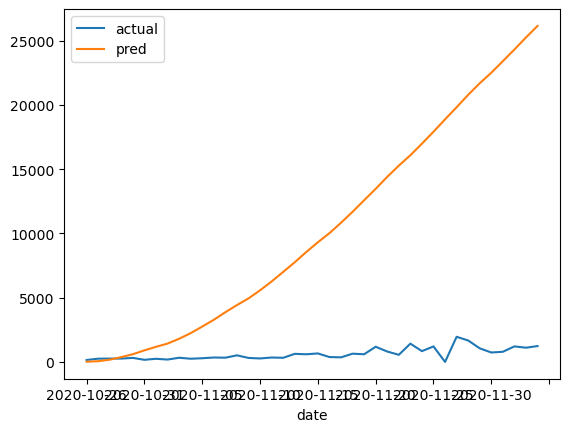

In [80]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

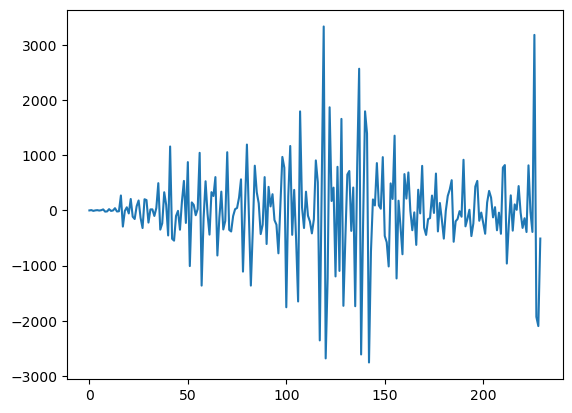

In [66]:
plt.plot(model.resid)

In [67]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                      incremental_cases   No. Observations:                  230
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 2], 7)   Log Likelihood               -1859.617
Date:                                Tue, 20 Feb 2024   AIC                           3727.234
Time:                                        14:38:43   BIC                           3740.986
Sample:                                             0   HQIC                          3732.781
                                                - 230                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6005      0.034    -17.512      0.000      -0.668      -0.533
ma.S.L7        0.2430      0.063      3.865      0.000       0.120       0.366
ma.S.L14      -0.1655      0.063     -2.636      0.008      -0.289      -0.042
sigma2      6.366e+05   3.68e+04     17.299      0.000    5.64e+05    7.09e+05
===================================================================================
Ljung-Box (L1) (Q):                  13.35   Jarque-Bera (JB):               160.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.83   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**NOTE**: Second model gives a better r_squared but looks like it has really bad predictions based on the graph. The third model has better predictions. 

Will continue to tune this one. 

## San Diego

In [68]:
sandiego = california_data[california_data['county'] == 'San Diego'].loc[:, ['date', 'incremental_cases']]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# Orange data is non-stationary without any differencing
stationary_test(sandiego.incremental_cases)

# test statistic (hypothesis that non-stationarity cannot be rejected)
# p-value is greater than 0.05 

(0.6357611259888307, 0.9884647007943559)

In [69]:
# first-level differencing
sandiego['incremental_cases'] = sandiego['incremental_cases'].diff().fillna(sandiego['incremental_cases']).astype('int')

# la is still non-stationary after first-level differencing
stationary_test(sandiego.incremental_cases)

# test statistic (hypothesis that non-stationarity cannot be rejected)
# p-value is greater than 0.05 

(-1.5064452750852018, 0.5303205781258837)

In [71]:
# second-level differencing
sandiego['incremental_cases'] = sandiego['incremental_cases'].diff().fillna(sandiego['incremental_cases']).astype('int')

# la is stationary after second-level differencing
stationary_test(sandiego.incremental_cases)

# test statistic (hypothesis that non-stationarity can be rejected)
# p-value is much less than 0.05

(-10.731247632565866, 2.9759568556391583e-19)

In [72]:
# using differenced cases for train
train = sandiego.iloc[:230, :]

<Axes: xlabel='date', ylabel='incremental_cases'>

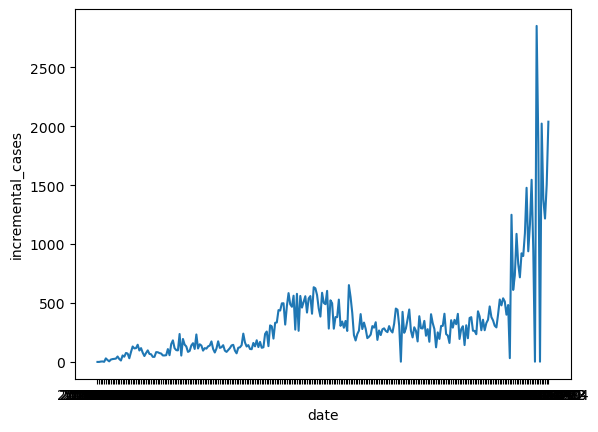

In [73]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'San Diego'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

### Baseline Model

In [74]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(0, 0, 0), seasonal_order=(1,1,1,7)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

R-squared -15.724846835540752


<Axes: xlabel='date'>

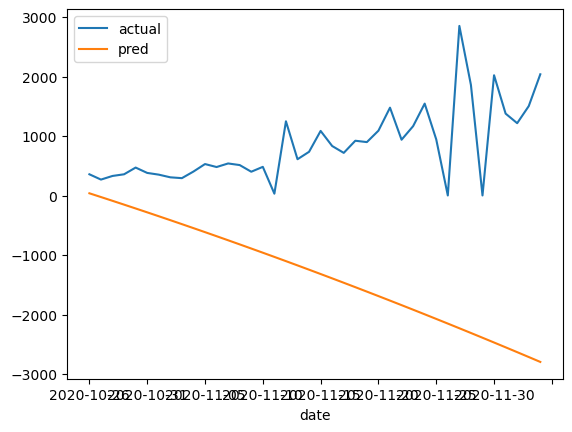

In [75]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

### Tuning Hyperparameters

In [33]:
p_values = [0, 1, 2, 3]
d_values = [0, 1, 2, 3]
q_values = [0, 1, 2, 3]

P_values = [0, 1, 2, 3]
D_values = [0, 1]
Q_values = [0, 1, 2, 3]
Season_length = [7]  # Assuming a weekly seasonality

prev_mse = float('inf')
best_params = (None, None)  # Initialized to a safer default

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for S in Season_length:
                            try:
                                model = SARIMAX(train.incremental_cases,
                                                order=(p, d, q),
                                                seasonal_order=(P, D, Q, S),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False).fit(disp=0)

                                pred = model.forecast(steps=40)
                                pred = pd.concat([pd.Series([-62]), pred]).cumsum()[1:]
                                pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]

                                mse = mean_squared_error(test.incremental_cases, pred)

                                if mse < prev_mse:
                                    prev_mse = mse
                                    best_params = ((p, d, q), (P, D, Q, S))

                                print(f"MSE: {mse} for parameters (p, d, q): {(p, d, q)} and (P, D, Q, S): {(P, D, Q, S)}")
                            except Exception as e:
                                print(f"Failed to fit model for parameters (p, d, q): {(p, d, q)}, (P, D, Q, S): {(P, D, Q, S)}. Error: {e}")

if best_params[0] is not None:
    print(f"Best Parameters: Non-seasonal (p, d, q): {best_params[0]}, Seasonal (P, D, Q, S): {best_params[1]} with MSE: {prev_mse}")
else:
    print("No successful model fit was found.")


3246037.3650726024 for parameters (1, 1, 1)
534858.7003346432 for parameters (1, 1, 5)
464419.3255563006 for parameters (1, 1, 10)
6017597365716197.0 for parameters (1, 5, 1)
5151989448.499466 for parameters (1, 5, 5)
685299701.5054859 for parameters (1, 5, 10)
2.9969571524973016e+22 for parameters (1, 8, 1)
2037578946594073.5 for parameters (1, 8, 5)
1.179095174775304e+22 for parameters (1, 8, 10)
437791.2089974845 for parameters (5, 1, 1)
660431.1597688368 for parameters (5, 1, 5)
534117.7737326123 for parameters (5, 1, 10)
318347523872487.94 for parameters (5, 5, 1)
1077698056690.7025 for parameters (5, 5, 5)
63612624.59589596 for parameters (5, 5, 10)
1.282272351243924e+20 for parameters (5, 8, 1)
4.845447803488334e+18 for parameters (5, 8, 5)
3.896075022154711e+16 for parameters (5, 8, 10)
574364.4334101771 for parameters (8, 1, 1)
588209.0577287807 for parameters (8, 1, 5)
478333.7779943969 for parameters (8, 1, 10)
25257920113353.383 for parameters (8, 5, 1)
42765464860.1483 for

In [34]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(0, 0, 0), seasonal_order=(1,1,1,7)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2

-0.13578540913728365

<Axes: xlabel='date'>

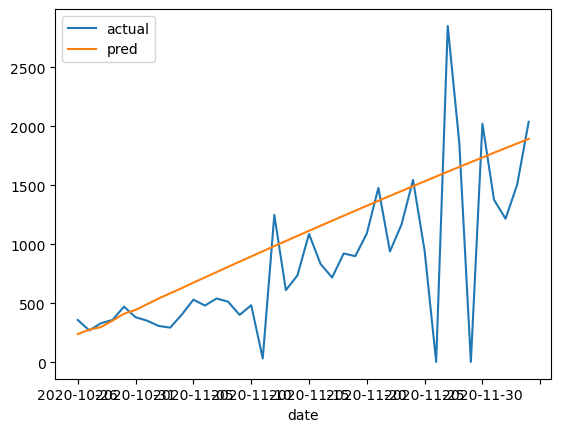

In [39]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

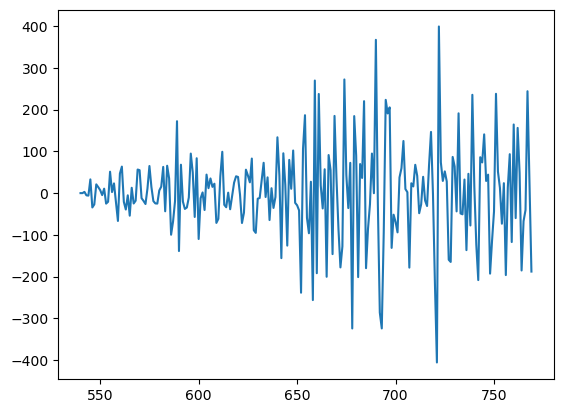

In [40]:
plt.plot(model.resid)

In [41]:
model.summary()

                               SARIMAX Results                                
Dep. Variable:      incremental_cases   No. Observations:                  230
Model:                 ARIMA(3, 2, 2)   Log Likelihood               -1407.650
Date:                Thu, 15 Feb 2024   AIC                           2827.300
Time:                        15:47:20   BIC                           2847.876
Sample:                             0   HQIC                          2835.602
                                - 230                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1607      0.055    -21.013      0.000      -1.269      -1.052
ar.L2         -0.7771      0.086     -9.062      0.000      -0.945      -0.609
ar.L3         -0.3166      0.069     -4.574      0.0

# Auto Arima Models for California Counties 

In [45]:
import pmdarima as pm
import pandas as pd

# Prophet univariate